# Step 0：环境准备 & 导入依赖

In [11]:
# Step 0: 环境 & 导入
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('.')    # 确保能 import src/
sys.path.append('./src')

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score

import torch
import torch.nn as nn
import torch.optim as optim

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# 自定义模块 (假设都在 src/ 里)
from src.dataset_manager import load_imbalanced_data, make_data_loaders
from src.model_builder import create_model
from src.train_utils import train_one_epoch, evaluate
# from src.gradcam_utils import show_gradcam    # 如果需要 Grad-CAM
from src.occlusion_utils import occlude_inference   # 遮挡测试

# 用于收集所有结果
all_results = []
print("Step 0 ready.")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda
Step 0 ready.


# Step 1: 加载正常数据 & 训练 (ResNet / MobileNet)

/root/.virtualenvs/comp9517_group_project/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/.virtualenvs/comp9517_group_project/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[NormalData-resnet18] Epoch 1/3, train_acc=0.8510, test_acc=0.9333
[NormalData-resnet18] Epoch 2/3, train_acc=0.9419, test_acc=0.9467
[NormalData-resnet18] Epoch 3/3, train_acc=0.9471, test_acc=0.9517


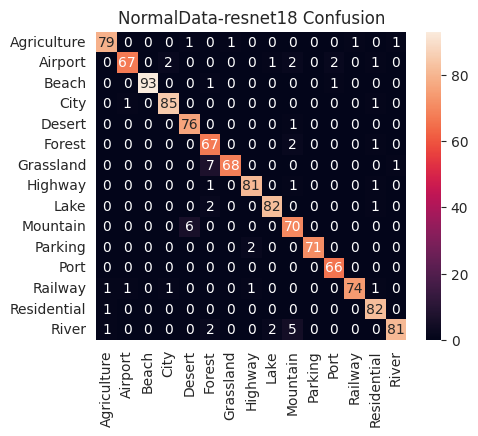

              precision    recall  f1-score   support

 Agriculture       0.96      0.95      0.96        83
     Airport       0.97      0.89      0.93        75
       Beach       1.00      0.98      0.99        95
        City       0.97      0.98      0.97        87
      Desert       0.92      0.99      0.95        77
      Forest       0.84      0.96      0.89        70
   Grassland       0.99      0.89      0.94        76
     Highway       0.96      0.96      0.96        84
        Lake       0.96      0.96      0.96        85
    Mountain       0.86      0.92      0.89        76
     Parking       1.00      0.97      0.99        73
        Port       0.96      1.00      0.98        66
     Railway       0.99      0.94      0.96        79
 Residential       0.93      0.99      0.96        83
       River       0.98      0.89      0.93        91

    accuracy                           0.95      1200
   macro avg       0.95      0.95      0.95      1200
weighted avg       0.95   

/root/.virtualenvs/comp9517_group_project/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/.virtualenvs/comp9517_group_project/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[NormalData-mobilenet_v2] Epoch 1/3, train_acc=0.8265, test_acc=0.9308
[NormalData-mobilenet_v2] Epoch 2/3, train_acc=0.9344, test_acc=0.9525
[NormalData-mobilenet_v2] Epoch 3/3, train_acc=0.9523, test_acc=0.9500


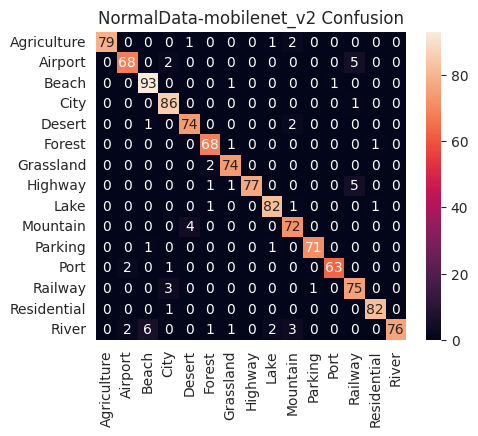

              precision    recall  f1-score   support

 Agriculture       1.00      0.95      0.98        83
     Airport       0.94      0.91      0.93        75
       Beach       0.92      0.98      0.95        95
        City       0.92      0.99      0.96        87
      Desert       0.94      0.96      0.95        77
      Forest       0.93      0.97      0.95        70
   Grassland       0.95      0.97      0.96        76
     Highway       1.00      0.92      0.96        84
        Lake       0.95      0.96      0.96        85
    Mountain       0.90      0.95      0.92        76
     Parking       0.99      0.97      0.98        73
        Port       0.98      0.95      0.97        66
     Railway       0.87      0.95      0.91        79
 Residential       0.98      0.99      0.98        83
       River       1.00      0.84      0.91        91

    accuracy                           0.95      1200
   macro avg       0.95      0.95      0.95      1200
weighted avg       0.95   

In [12]:
# Step 1: 普通数据集 (无不平衡)
DATA_DIR = "../Aerial_Landscapes"        # 数据目录
TEST_RATIO = 0.2
SAMPLE_RATIO = 0.5
REDUCE_FACTOR = 1.0      # 不减少任何类
BATCH_SIZE = 16
IM_SIZE = 224
RANDOM_SEED = 42

train_paths, train_labels, test_paths, test_labels, class_names = load_imbalanced_data(
    root_folder=DATA_DIR,
    test_ratio=TEST_RATIO,
    sample_ratio=SAMPLE_RATIO,
    reduce_factor=REDUCE_FACTOR,
    minority_classes=[],   # 不指定少数类
    random_seed=RANDOM_SEED
)
train_loader, test_loader = make_data_loaders(
    train_paths, train_labels,
    test_paths, test_labels,
    class_names,
    batch_size=BATCH_SIZE,
    im_size=IM_SIZE
)
NUM_CLASSES = len(class_names)

def train_and_return_metrics(model_name, scenario="NormalData", epochs=3, lr=1e-4):
    start_time = time.time()
    model = create_model(model_name, num_classes=NUM_CLASSES, pretrained=True)
    model.to(DEVICE)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_acc = 0
    for ep in range(1, epochs+1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
        val_loss, val_acc, preds, labs = evaluate(model, test_loader, criterion, DEVICE)
        if val_acc > best_acc:
            best_acc = val_acc

        print(f"[{scenario}-{model_name}] Epoch {ep}/{epochs}, train_acc={tr_acc:.4f}, test_acc={val_acc:.4f}")

    train_time = time.time() - start_time

    # 计算更多指标
    acc = accuracy_score(labs, preds)
    f1 = f1_score(labs, preds, average='weighted')
    prec = precision_score(labs, preds, average='weighted')
    rec = recall_score(labs, preds, average='weighted')

    # 混淆矩阵 & 报告
    cm = confusion_matrix(labs, preds)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{scenario}-{model_name} Confusion")
    plt.show()

    cr = classification_report(labs, preds, target_names=class_names)
    print(cr)

    # 记录
    all_results.append({
        "Scenario": scenario,
        "Model": model_name,
        "Accuracy": f"{acc*100:.2f}%",
        "F1": f"{f1:.3f}",
        "Precision": f"{prec:.3f}",
        "Recall": f"{rec:.3f}",
        "TrainTime(s)": f"{train_time:.1f}"
    })
    return model

# 训练 & 评估 ResNet18
resnet_normal = train_and_return_metrics("resnet18", scenario="NormalData", epochs=3, lr=1e-4)
# 训练 & 评估 MobileNetV2
mobilenet_normal = train_and_return_metrics("mobilenet_v2", scenario="NormalData", epochs=3, lr=1e-4)

print("Step 1 done.")


# Step 2: 不平衡数据集 & 再次训练

/root/.virtualenvs/comp9517_group_project/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/.virtualenvs/comp9517_group_project/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Imbalanced-resnet18] Epoch 1/3, train_acc=0.8421, test_acc=0.9375
[Imbalanced-resnet18] Epoch 2/3, train_acc=0.9412, test_acc=0.9621
[Imbalanced-resnet18] Epoch 3/3, train_acc=0.9569, test_acc=0.9157


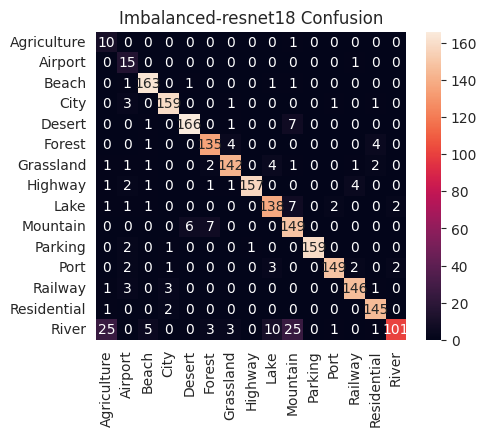

              precision    recall  f1-score   support

 Agriculture       0.25      0.91      0.39        11
     Airport       0.50      0.94      0.65        16
       Beach       0.94      0.98      0.96       167
        City       0.96      0.96      0.96       165
      Desert       0.96      0.95      0.95       175
      Forest       0.91      0.94      0.92       144
   Grassland       0.93      0.92      0.93       155
     Highway       0.99      0.94      0.97       167
        Lake       0.88      0.91      0.90       152
    Mountain       0.78      0.92      0.84       162
     Parking       1.00      0.98      0.99       163
        Port       0.97      0.94      0.96       159
     Railway       0.95      0.95      0.95       154
 Residential       0.94      0.98      0.96       148
       River       0.96      0.58      0.72       174

    accuracy                           0.92      2112
   macro avg       0.86      0.92      0.87      2112
weighted avg       0.93   

/root/.virtualenvs/comp9517_group_project/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/.virtualenvs/comp9517_group_project/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Imbalanced-mobilenet_v2] Epoch 1/3, train_acc=0.8129, test_acc=0.9474
[Imbalanced-mobilenet_v2] Epoch 2/3, train_acc=0.9437, test_acc=0.9564
[Imbalanced-mobilenet_v2] Epoch 3/3, train_acc=0.9551, test_acc=0.9545


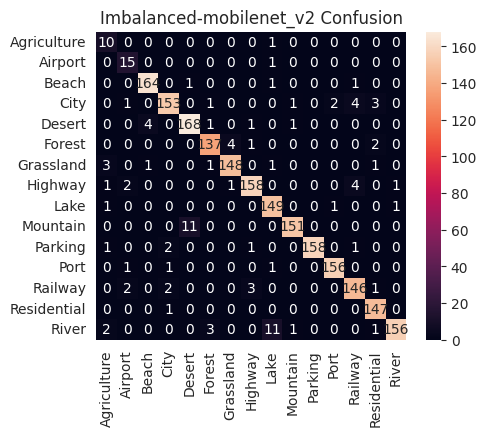

              precision    recall  f1-score   support

 Agriculture       0.56      0.91      0.69        11
     Airport       0.71      0.94      0.81        16
       Beach       0.97      0.98      0.98       167
        City       0.96      0.93      0.94       165
      Desert       0.93      0.96      0.95       175
      Forest       0.96      0.95      0.95       144
   Grassland       0.97      0.95      0.96       155
     Highway       0.96      0.95      0.95       167
        Lake       0.90      0.98      0.94       152
    Mountain       0.98      0.93      0.96       162
     Parking       1.00      0.97      0.98       163
        Port       0.98      0.98      0.98       159
     Railway       0.94      0.95      0.94       154
 Residential       0.95      0.99      0.97       148
       River       0.99      0.90      0.94       174

    accuracy                           0.95      2112
   macro avg       0.92      0.95      0.93      2112
weighted avg       0.96   

In [13]:
# Step 2: 不平衡数据
MINORITY_CLASSES = [0,1]  # 人为指定减少第0,1类
REDUCE_FACTOR = 0.1       # 减少到10%
scenario_imb = "Imbalanced"

train_paths_imb, train_labels_imb, test_paths_imb, test_labels_imb, class_names_imb = load_imbalanced_data(
    root_folder=DATA_DIR,
    test_ratio=TEST_RATIO,
    sample_ratio=1.0,      # 其他类不缩减
    reduce_factor=REDUCE_FACTOR,
    minority_classes=MINORITY_CLASSES,
    random_seed=RANDOM_SEED
)
train_loader_imb, test_loader_imb = make_data_loaders(
    train_paths_imb, train_labels_imb,
    test_paths_imb, test_labels_imb,
    class_names_imb,
    batch_size=BATCH_SIZE,
    im_size=IM_SIZE
)
NUM_CLASSES_IMB = len(class_names_imb)

def train_imb_and_return_metrics(model_name, scenario="Imbalanced", epochs=3, lr=1e-4):
    import numpy as np
    from collections import Counter
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

    start_time = time.time()
    model = create_model(model_name, num_classes=NUM_CLASSES_IMB, pretrained=True)
    model.to(DEVICE)

    # 计算 class_weight
    label_counts = Counter(train_labels_imb)
    c_array = np.array([label_counts.get(i,0) for i in range(NUM_CLASSES_IMB)], dtype=np.float32)
    inv_c = 1.0/(c_array + 1e-7)
    inv_c /= inv_c.sum() / NUM_CLASSES_IMB
    weight_tensor = torch.tensor(inv_c).to(DEVICE)

    criterion = nn.CrossEntropyLoss(weight=weight_tensor)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_acc = 0
    for ep in range(1, epochs+1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader_imb, optimizer, criterion, DEVICE)
        val_loss, val_acc, preds, labs = evaluate(model, test_loader_imb, criterion, DEVICE)
        if val_acc > best_acc:
            best_acc = val_acc
        print(f"[{scenario}-{model_name}] Epoch {ep}/{epochs}, train_acc={tr_acc:.4f}, test_acc={val_acc:.4f}")

    train_time = time.time() - start_time
    acc = accuracy_score(labs, preds)
    f1 = f1_score(labs, preds, average='weighted')
    prec = precision_score(labs, preds, average='weighted')
    rec = recall_score(labs, preds, average='weighted')

    cm = confusion_matrix(labs, preds)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names_imb, yticklabels=class_names_imb)
    plt.title(f"{scenario}-{model_name} Confusion")
    plt.show()

    cr = classification_report(labs, preds, target_names=class_names_imb)
    print(cr)

    all_results.append({
        "Scenario": scenario,
        "Model": model_name,
        "Accuracy": f"{acc*100:.2f}%",
        "F1": f"{f1:.3f}",
        "Precision": f"{prec:.3f}",
        "Recall": f"{rec:.3f}",
        "TrainTime(s)": f"{train_time:.1f}"
    })
    return model

# 不平衡: ResNet
resnet_imb = train_imb_and_return_metrics("resnet18", scenario=scenario_imb, epochs=3, lr=1e-4)
# 不平衡: MobileNet
mobilenet_imb = train_imb_and_return_metrics("mobilenet_v2", scenario=scenario_imb, epochs=3, lr=1e-4)

print("Step 2 done.")


# Step 3: 遮挡/噪声处理 + 对比结果


===[OcclusionTest_Normal_ResNet]===  resnet_normal occlude_size=60
遮挡后: Acc=0.730, F1=0.760, Precision=0.888, Recall=0.730


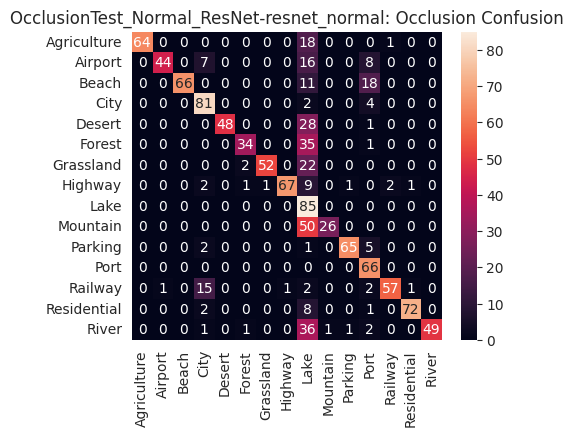

Classification Report (遮挡后):
              precision    recall  f1-score   support

 Agriculture       1.00      0.77      0.87        83
     Airport       0.98      0.59      0.73        75
       Beach       1.00      0.69      0.82        95
        City       0.74      0.93      0.82        87
      Desert       1.00      0.62      0.77        77
      Forest       0.89      0.49      0.63        70
   Grassland       0.98      0.68      0.81        76
     Highway       0.99      0.80      0.88        84
        Lake       0.26      1.00      0.42        85
    Mountain       0.96      0.34      0.50        76
     Parking       0.97      0.89      0.93        73
        Port       0.61      1.00      0.76        66
     Railway       0.95      0.72      0.82        79
 Residential       0.97      0.87      0.92        83
       River       1.00      0.54      0.70        91

    accuracy                           0.73      1200
   macro avg       0.89      0.73      0.76      12

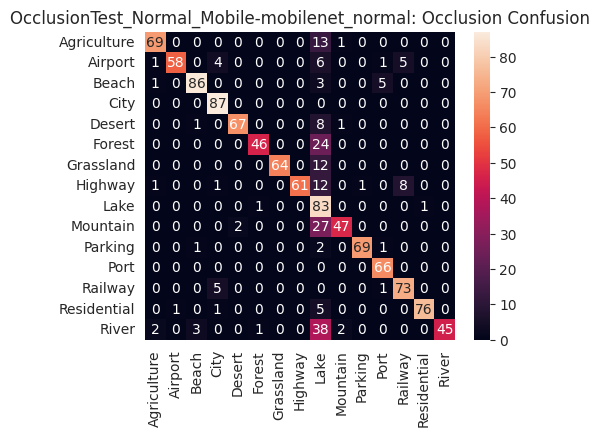

Classification Report (遮挡后):
              precision    recall  f1-score   support

 Agriculture       0.93      0.83      0.88        83
     Airport       0.98      0.77      0.87        75
       Beach       0.95      0.91      0.92        95
        City       0.89      1.00      0.94        87
      Desert       0.97      0.87      0.92        77
      Forest       0.96      0.66      0.78        70
   Grassland       1.00      0.84      0.91        76
     Highway       1.00      0.73      0.84        84
        Lake       0.36      0.98      0.52        85
    Mountain       0.92      0.62      0.74        76
     Parking       0.99      0.95      0.97        73
        Port       0.89      1.00      0.94        66
     Railway       0.85      0.92      0.88        79
 Residential       0.99      0.92      0.95        83
       River       1.00      0.49      0.66        91

    accuracy                           0.83      1200
   macro avg       0.91      0.83      0.85      12

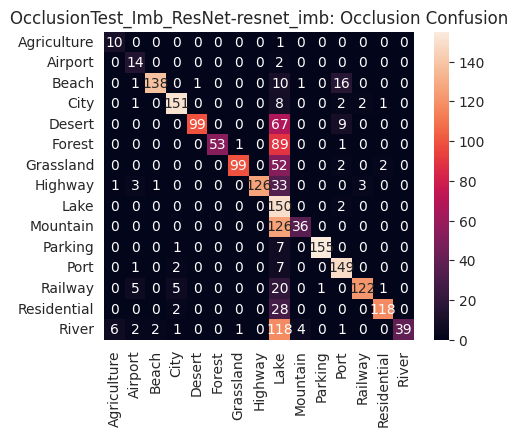

Classification Report (遮挡后):
              precision    recall  f1-score   support

 Agriculture       0.59      0.91      0.71        11
     Airport       0.52      0.88      0.65        16
       Beach       0.98      0.83      0.90       167
        City       0.93      0.92      0.92       165
      Desert       0.99      0.57      0.72       175
      Forest       1.00      0.37      0.54       144
   Grassland       0.98      0.64      0.77       155
     Highway       1.00      0.75      0.86       167
        Lake       0.21      0.99      0.34       152
    Mountain       0.88      0.22      0.35       162
     Parking       0.99      0.95      0.97       163
        Port       0.82      0.94      0.87       159
     Railway       0.96      0.79      0.87       154
 Residential       0.97      0.80      0.87       148
       River       1.00      0.22      0.37       174

    accuracy                           0.69      2112
   macro avg       0.85      0.72      0.72      21

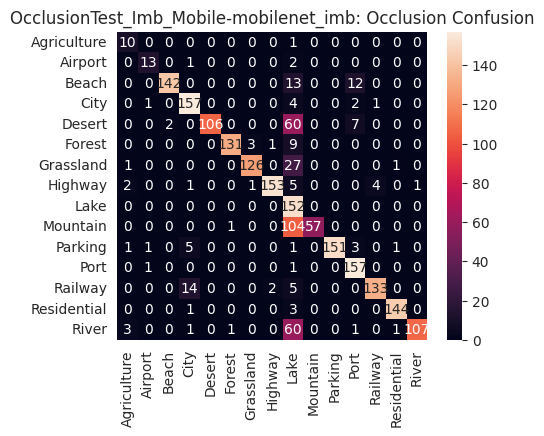

Classification Report (遮挡后):
              precision    recall  f1-score   support

 Agriculture       0.59      0.91      0.71        11
     Airport       0.81      0.81      0.81        16
       Beach       0.99      0.85      0.91       167
        City       0.87      0.95      0.91       165
      Desert       1.00      0.61      0.75       175
      Forest       0.98      0.91      0.95       144
   Grassland       0.97      0.81      0.88       155
     Highway       0.98      0.92      0.95       167
        Lake       0.34      1.00      0.51       152
    Mountain       1.00      0.35      0.52       162
     Parking       1.00      0.93      0.96       163
        Port       0.86      0.99      0.92       159
     Railway       0.96      0.86      0.91       154
 Residential       0.98      0.97      0.98       148
       River       0.99      0.61      0.76       174

    accuracy                           0.82      2112
   macro avg       0.89      0.83      0.83      21

In [17]:
# Step 3: 遮挡/噪声处理 + 评分 (只输出遮挡后)

from src.occlusion_utils import occlusion_test_evaluation
import torchvision.transforms as T

# 确保跟训练时Normalize一致
test_transform = T.Compose([
    T.ToPILImage(),
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# 1) 对 normalData 的 ResNet18
occlusion_test_evaluation(
    model=resnet_normal,
    test_paths=test_paths,
    test_labels=test_labels,
    transform=test_transform,
    device=DEVICE,
    occlude_size=60,
    scenario="OcclusionTest_Normal_ResNet",
    model_name="resnet_normal",
    class_names=class_names,
    results_list=all_results
)

# 2) 对 normalData 的 MobileNetV2
occlusion_test_evaluation(
    model=mobilenet_normal,
    test_paths=test_paths,
    test_labels=test_labels,
    transform=test_transform,
    device=DEVICE,
    occlude_size=60,
    scenario="OcclusionTest_Normal_Mobile",
    model_name="mobilenet_normal",
    class_names=class_names,
    results_list=all_results
)

#  不平衡模型 test 做同样的遮挡评估
occlusion_test_evaluation(
    model=resnet_imb,
    test_paths=test_paths_imb,
    test_labels=test_labels_imb,
    transform=test_transform,
    device=DEVICE,
    occlude_size=60,
    scenario="OcclusionTest_Imb_ResNet",
    model_name="resnet_imb",
    class_names=class_names_imb,
    results_list=all_results
)

occlusion_test_evaluation(
    model=mobilenet_imb,
    test_paths=test_paths_imb,
    test_labels=test_labels_imb,
    transform=test_transform,
    device=DEVICE,
    occlude_size=60,
    scenario="OcclusionTest_Imb_Mobile",
    model_name="mobilenet_imb",
    class_names=class_names_imb,
    results_list=all_results
)

print("Step 3: Finished occlusion test with overall metrics.")


# Step 4: 输出所有结果对比

In [18]:
# Step 4: 输出对比表格
df_all = pd.DataFrame(all_results)
print(df_all)

print("\n=== Summary Table ===")
print(df_all.to_markdown(index=False))

# 也可保存CSV
df_all.to_csv("final_comparison.csv", index=False)

print("All experiments completed. Results saved in final_comparison.csv.")


                       Scenario             Model Accuracy     F1 Precision  \
0                    NormalData          resnet18   95.17%  0.952     0.954   
1                    NormalData      mobilenet_v2   95.00%  0.950     0.952   
2                    Imbalanced          resnet18   91.57%  0.918     0.932   
3                    Imbalanced      mobilenet_v2   95.45%  0.955     0.957   
4          OcclusionTest_Normal          resnet18      N/A    N/A       N/A   
5          OcclusionTest_Normal      mobilenet_v2      N/A    N/A       N/A   
6             OcclusionTest_Imb          resnet18      N/A    N/A       N/A   
7             OcclusionTest_Imb      mobilenet_v2      N/A    N/A       N/A   
8   OcclusionTest_Normal_ResNet     resnet_normal   73.00%  0.760     0.888   
9   OcclusionTest_Normal_Mobile  mobilenet_normal   83.08%  0.846     0.909   
10     OcclusionTest_Imb_ResNet        resnet_imb   69.08%  0.720     0.899   
11     OcclusionTest_Imb_Mobile     mobilenet_imb   